### Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

### Data

In [ ]:
df = pd.read_csv("taxi_pickups_area.csv")

In [ ]:
df

,Trip Start Timestamp,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
0,2019-04-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2019-04-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2,2019-04-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,2019-04-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2019-04-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8059,2019-06-23 22:45:00,4.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
8060,2019-06-23 23:00:00,3.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
8061,2019-06-23 23:15:00,3.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0
8062,2019-06-23 23:30:00,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0


In [ ]:
areas = df.columns[1:].tolist()
forecast_horizon = 673

test_df = df.iloc[-forecast_horizon:]
train_valid_df = df.iloc[:-forecast_horizon]
valid_df = train_valid_df.iloc[-forecast_horizon:]
train_df = train_valid_df.iloc[:-forecast_horizon]

print("Train:", train_df.shape, " | Valid:", valid_df.shape, " | Test:", test_df.shape)

Train: (6718, 79)  | Valid: (673, 79)  | Test: (673, 79)


### Exploratory Data Analysis (EDA)

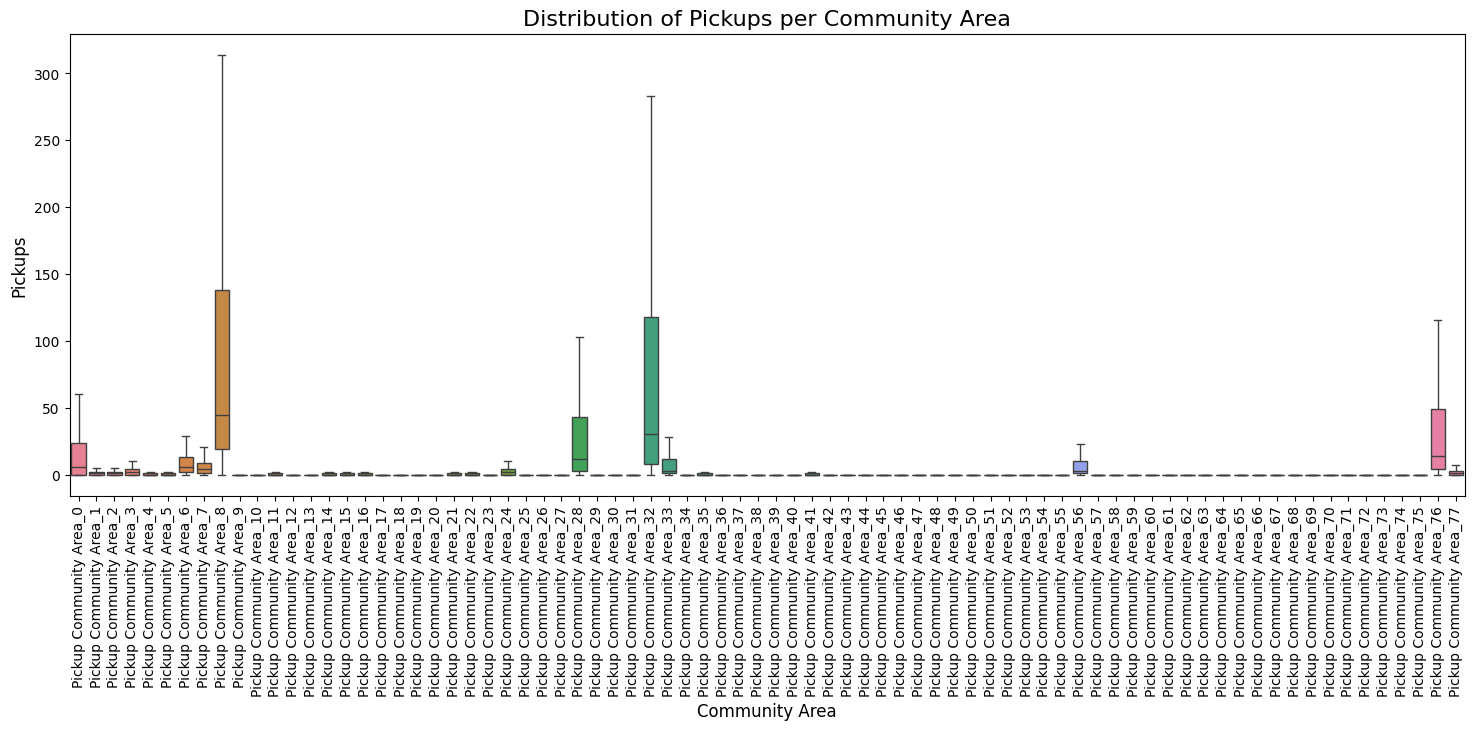

In [ ]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=df, showfliers=False)
plt.title('Distribution of Pickups per Community Area', fontsize=16)
plt.xlabel('Community Area', fontsize=12)
plt.ylabel('Pickups', fontsize=12)
plt.xticks(rotation=90)
plt.show()

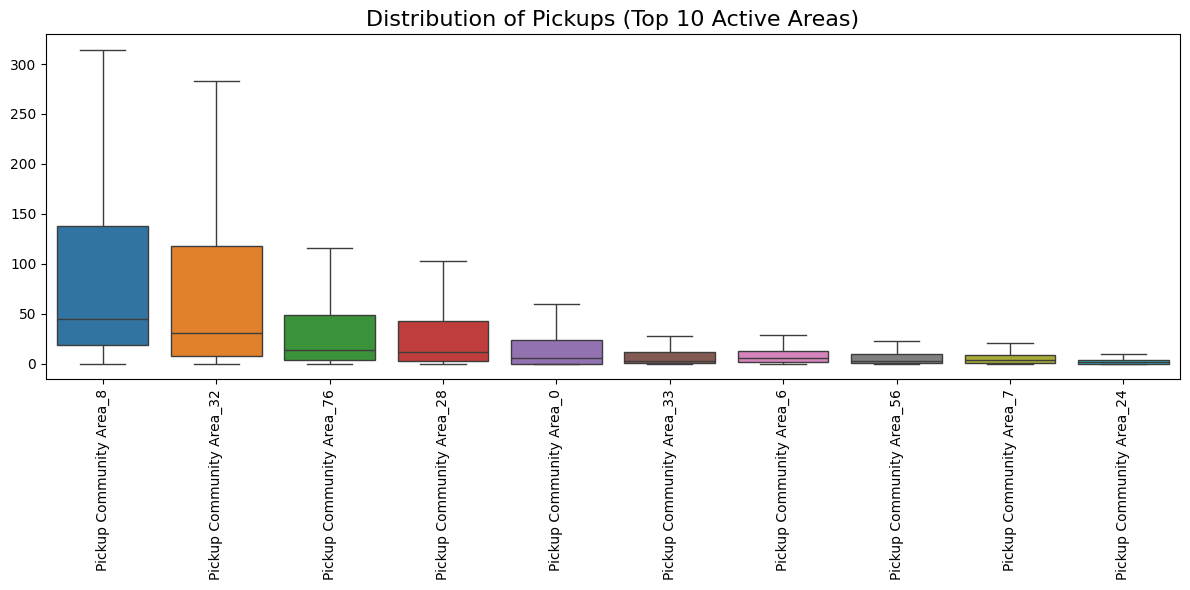

In [ ]:
top_10_areas = df.iloc[:, 1:].mean().sort_values(ascending=False).head(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[top_10_areas], showfliers=False)
plt.title('Distribution of Pickups (Top 10 Active Areas)', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

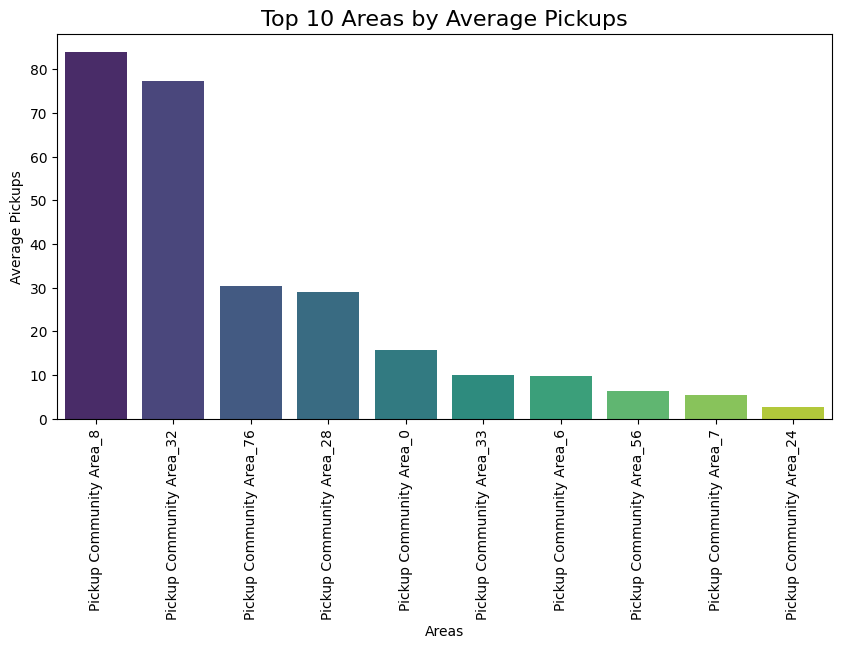

In [ ]:
mean_pickups = df.iloc[:, 1:].mean().sort_values(ascending=False)
top_10 = mean_pickups.head(10)
plt.figure(figsize=(10, 5))
sns.barplot(
    x=top_10.index,
    y=top_10.values,
    hue=top_10.index,
    palette='viridis',
    dodge=False
)
plt.xticks(rotation=90)
plt.title('Top 10 Areas by Average Pickups', fontsize=16)
plt.xlabel('Areas')
plt.ylabel('Average Pickups')
plt.show()

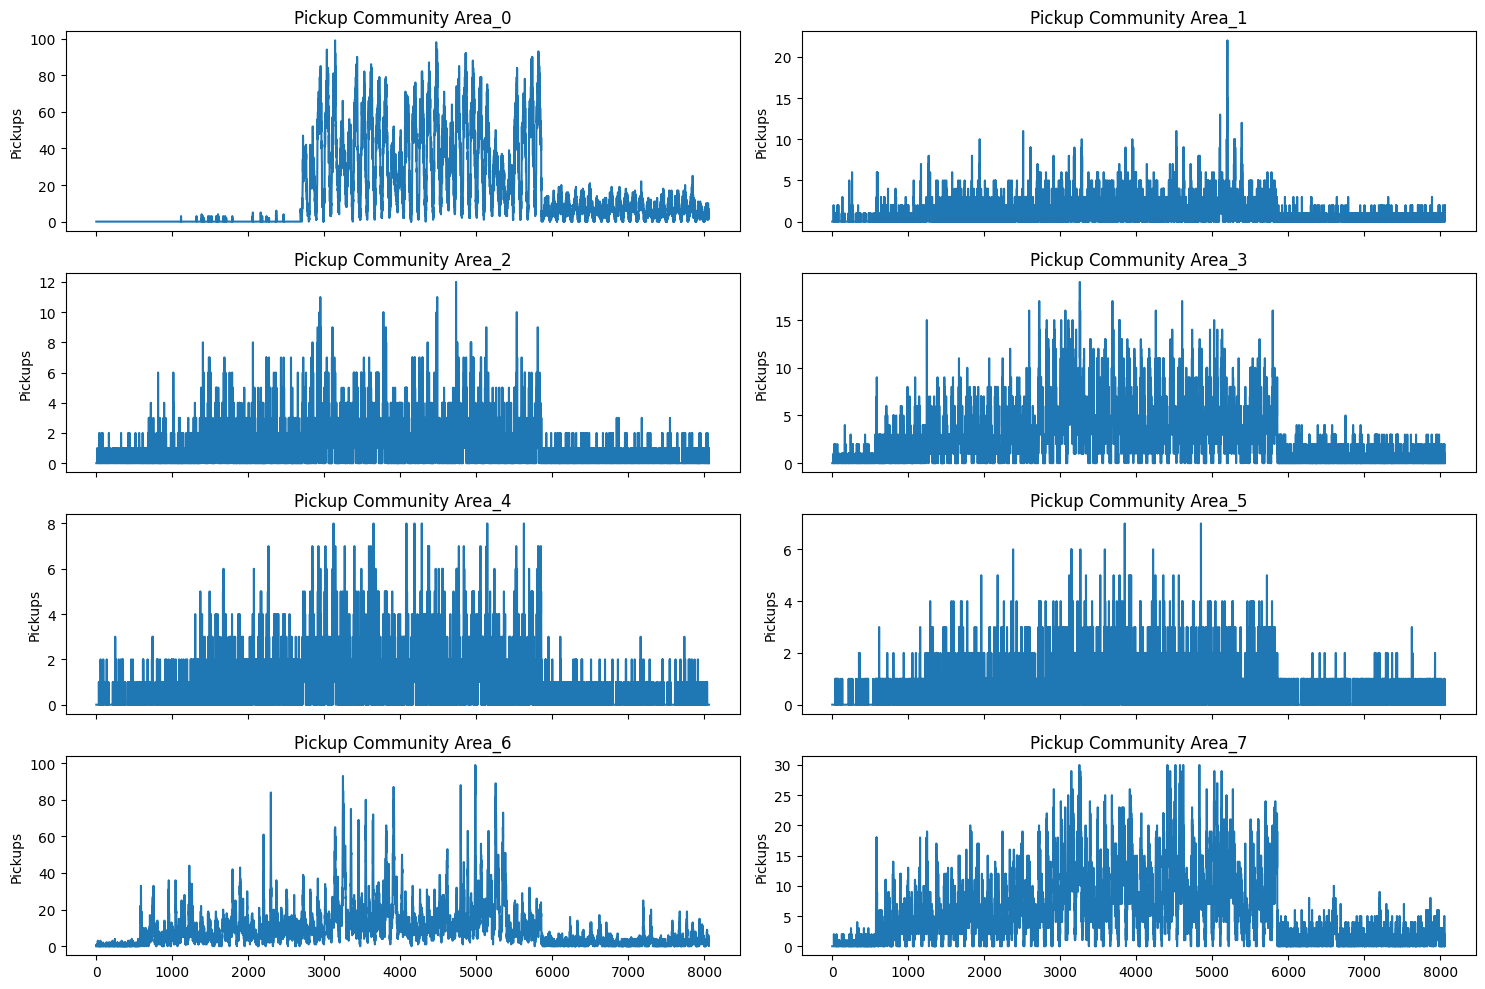

In [ ]:
areas_to_plot = df.columns[1:9]
fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()

for i, area in enumerate(areas_to_plot):
    axes[i].plot(df[area], color='tab:blue')
    axes[i].set_title(area, fontsize=12)
    axes[i].set_ylabel('Pickups')
plt.tight_layout()
plt.show()

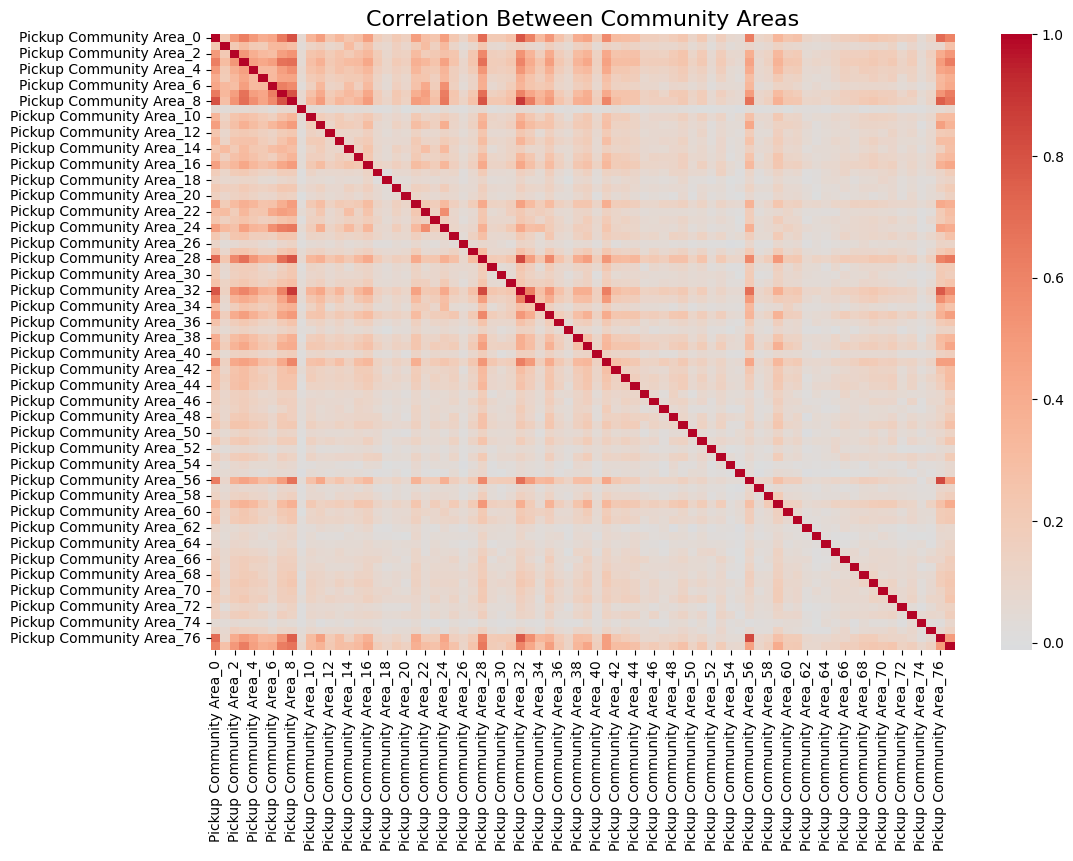

In [ ]:
corr = df.iloc[:, 1:].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Between Community Areas', fontsize=16)
plt.show()

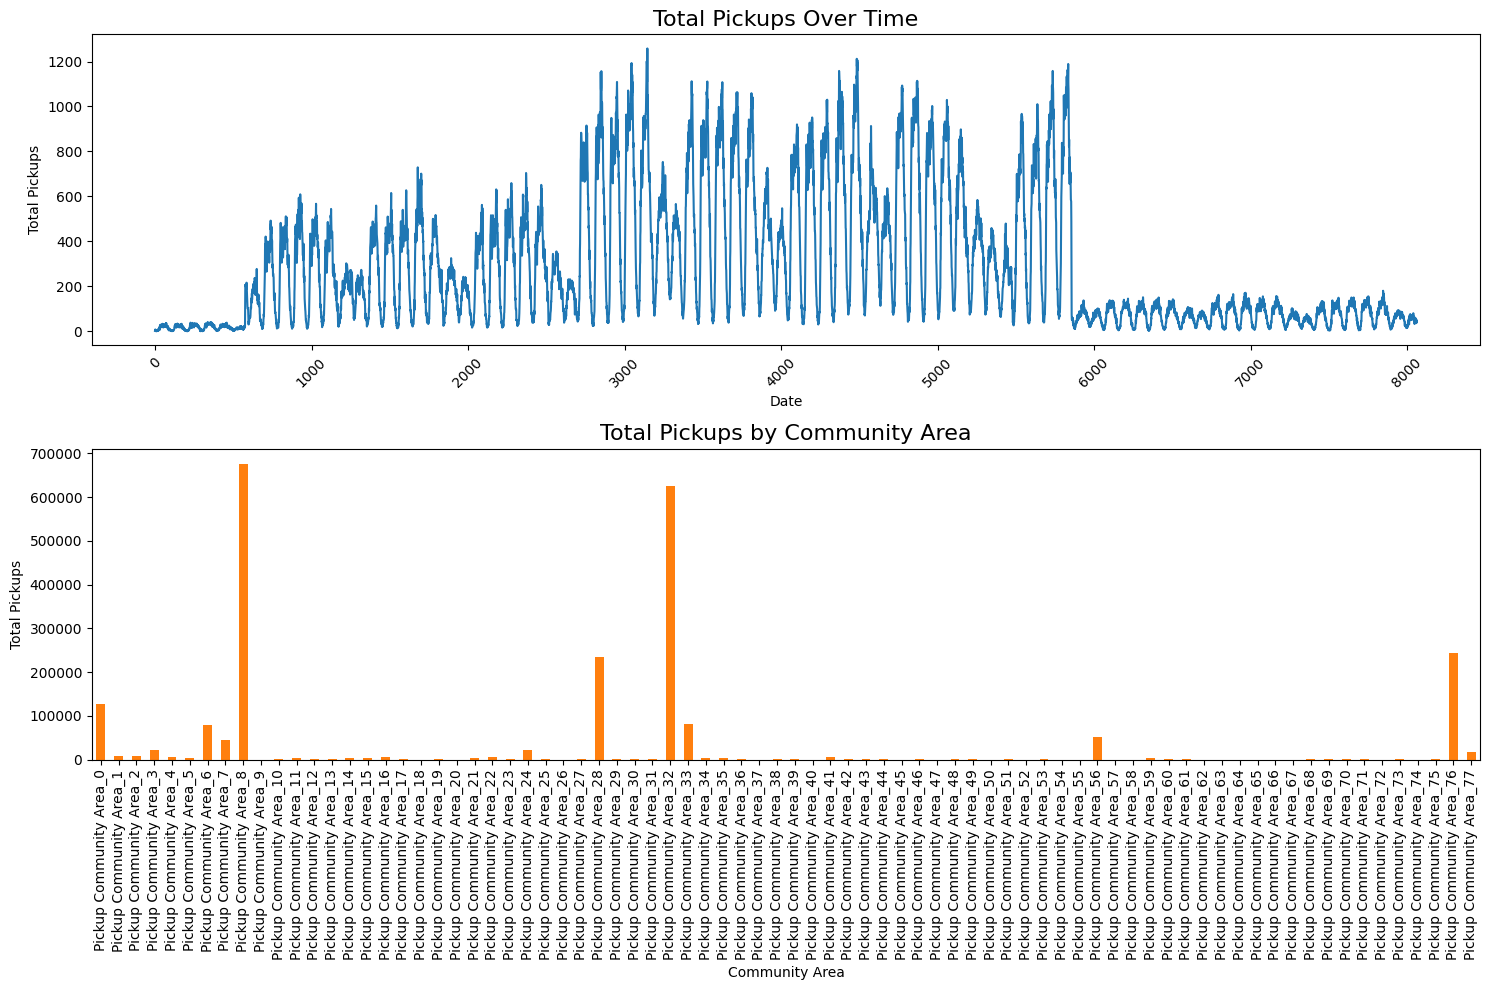

In [ ]:
total_pickups_over_time = df.iloc[:, 1:].sum(axis=1)
total_pickups_by_area = df.iloc[:, 1:].sum(axis=0)

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(df.index, total_pickups_over_time, color='tab:blue')
axes[0].set_title('Total Pickups Over Time', fontsize=16)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Pickups')
axes[0].tick_params(axis='x', rotation=45)

total_pickups_by_area.plot(kind='bar', ax=axes[1], color='tab:orange')
axes[1].set_title('Total Pickups by Community Area', fontsize=16)
axes[1].set_xlabel('Community Area')
axes[1].set_ylabel('Total Pickups')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Naive averages

In [ ]:
naive_preds = pd.DataFrame(index=valid_df.index, columns=areas)
for area in areas:
    naive_preds[area] = train_df[area].mean()

mae_naive = mean_absolute_error(valid_df[areas], naive_preds)
print("Naive Average MAE:", mae_naive)

Naive Average MAE: 3.391557591980089


### Moving averages

In [ ]:
window_sizes = [4, 96, 672]  # 1 hour, 1 day, 1 week
ma_preds = pd.DataFrame(index=valid_df.index, columns=areas)

for area in areas:
    best_mae = np.inf
    for w in window_sizes:
        if len(train_df[area]) < w: continue
        pred = np.full(len(valid_df), train_df[area].iloc[-w:].mean())
        mae = mean_absolute_error(valid_df[area], pred)
        if mae < best_mae:
            best_mae = mae
            best_pred = pred
    ma_preds[area] = best_pred

mae_ma = mean_absolute_error(valid_df[areas], ma_preds)
print("Moving Average MAE:", mae_ma)

Moving Average MAE: 0.6339668411083718


### Exponential Smoothing

In [ ]:
# SES: Simple Exponential Smoothing (no trend or seasonality)
def ses_forecast(series, forecast_horizon, alpha=0.7):
    """
    series: historical data (1D array or pd.Series)
    forecast_horizon: number of future points to forecast
    alpha: smoothing parameter (0 < alpha <= 1)
    """
    forecast = np.zeros(forecast_horizon)  # initialize forecast array
    l = series[0]  # initial level (first observation)

    # Update level for each observation
    for t in range(len(series)):
        l = alpha * series[t] + (1 - alpha) * l  # exponential smoothing formula

    # Forecast is simply the last level repeated for all future points
    forecast[:] = l
    return forecast

# Holt: Linear Trend method (handles trend, no seasonality)
def holt_forecast(series, forecast_horizon, alpha=0.7, beta=0.2):
    """
    alpha: level smoothing
    beta: trend smoothing
    """
    l = series[0]               # initial level
    b = series[1] - series[0]   # initial trend estimate (first difference)

    # Update level and trend for each observation
    for t in range(1, len(series)):
        prev_l = l
        l = alpha * series[t] + (1 - alpha) * (l + b)  # update level
        b = beta * (l - prev_l) + (1 - beta) * b       # update trend

    # Forecast future points: linear extrapolation using last level and trend
    forecast = np.array([l + (h+1)*b for h in range(forecast_horizon)])
    return forecast

# Holt-Winters: Additive (trend + seasonality)
def holt_winters_additive(series, alpha, beta, gamma, season_len, n_forecast):
    """
    series: historical data
    alpha: level smoothing
    beta: trend smoothing
    gamma: seasonal smoothing
    season_len: length of the seasonal cycle (e.g., 12 for monthly)
    n_forecast: number of future points to forecast
    """
    # Initialize level and trend
    l = np.mean(series[:season_len])  # average of first season
    b = (np.mean(series[season_len:2*season_len]) - l) / season_len  # initial trend

    # Initialize seasonal components
    s = series[:season_len] - l  # initial seasonal deviations
    s = list(s)  # convert to list for easy update

    # Update level, trend, and seasonality
    for t in range(len(series)):
        s_idx = t % season_len  # index of seasonal component
        prev_l = l
        prev_s = s[s_idx]

        l = alpha * (series[t] - s[s_idx]) + (1 - alpha) * (l + b)  # update level
        b = beta * (l - prev_l) + (1 - beta) * b                     # update trend
        s[s_idx] = gamma * (series[t] - l) + (1 - gamma) * s[s_idx] # update seasonality

    # Forecast future points
    forecast = np.zeros(n_forecast)
    for h in range(n_forecast):
        s_idx = (len(series) + h) % season_len  # seasonal index for forecast
        forecast[h] = l + (h+1)*b + s[s_idx]    # level + trend + seasonality

    return forecast

In [ ]:
es_preds = pd.DataFrame(index=valid_df.index, columns=areas)
best_methods = {}

for area in areas:
    series = train_df[area].astype(float)
    best_mae = np.inf
    best_forecast = np.full(len(valid_df), series.mean())
    best_method = "Mean"

    try:
        ses = SimpleExpSmoothing(series).fit(optimized=True)
        f_ses = ses.forecast(len(valid_df))
        mae_ses = mean_absolute_error(valid_df[area], f_ses)
        if mae_ses < best_mae:
            best_mae, best_forecast, best_method = mae_ses, f_ses, "SES"
    except: pass

    try:
        holt = Holt(series).fit(optimized=True)
        f_holt = holt.forecast(len(valid_df))
        mae_holt = mean_absolute_error(valid_df[area], f_holt)
        if mae_holt < best_mae:
            best_mae, best_forecast, best_method = mae_holt, f_holt, "Holt"
    except: pass

    try:
        hw = ExponentialSmoothing(series, trend="add", seasonal="add",
                                  seasonal_periods=96).fit(optimized=True)
        f_hw = hw.forecast(len(valid_df))
        mae_hw = mean_absolute_error(valid_df[area], f_hw)
        if mae_hw < best_mae:
            best_mae, best_forecast, best_method = mae_hw, f_hw, "HW"
    except: pass

    es_preds[area] = best_forecast
    best_methods[area] = best_method

mae_es = mean_absolute_error(valid_df[areas], es_preds)
print("Exponential Smoothing MAE:", mae_es)

Exponential Smoothing MAE: 0.7779965553992568


### ARIMA / SARIMA

In [ ]:
def manual_sarima_forecast(series, forecast_horizon,
                           p_values=[0,1,2], d_values=[0,1], q_values=[0,1,2],
                           P_values=[0,1], D_values=[0,1], Q_values=[0,1],
                           seasonal_period=96):
    """
    Manual SARIMA forecast function.

    Parameters:
    - series: historical time series data (1D array or pd.Series)
    - forecast_horizon: number of future points to forecast
    - p_values, d_values, q_values: ranges for ARIMA parameters
    - P_values, D_values, Q_values: ranges for seasonal ARIMA parameters
    - seasonal_period: seasonal cycle length (e.g., 96 for daily seasonality in 15-min intervals)

    Returns:
    - forecast: numpy array of length forecast_horizon
    """

    best_aic = np.inf       # Initialize best AIC to a very large number
    best_model = None       # Placeholder for the best SARIMAX model

    # -----------------------------
    # Grid search over all ARIMA and seasonal parameters
    # -----------------------------
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                # Define SARIMAX model with current parameters
                                model = SARIMAX(series,
                                                order=(p,d,q),                      # ARIMA part
                                                seasonal_order=(P,D,Q,seasonal_period),  # Seasonal part
                                                enforce_stationarity=False,         # allow non-stationary series
                                                enforce_invertibility=False)        # allow non-invertible MA terms

                                # Fit the model
                                results = model.fit(disp=False)

                                # Keep the model if it has the lowest AIC so far
                                if results.aic < best_aic:
                                    best_aic = results.aic
                                    best_model = results

                            except:
                                # Skip invalid parameter combinations that fail to converge
                                continue

    # -----------------------------
    # Forecast using the best model
    # -----------------------------
    if best_model is not None:
        forecast = best_model.forecast(steps=forecast_horizon)
    else:
        # Fallback: if no model converged, use the mean of the historical series
        forecast = np.full(forecast_horizon, series.mean())

    return forecast

In [ ]:
sarima_preds = pd.DataFrame(index=valid_df.index, columns=areas)
best_params = {}

for area in areas:
    series = train_df[area].astype(float)
    forecast = manual_sarima_forecast(series, forecast_horizon=673)
    sarima_preds[area] = forecast

mae_sarima = mean_absolute_error(valid_df[areas], sarima_preds)
print("SARIMA MAE:", mae_sarima)

### Evaluation & Submission

In [ ]:
# Weighted average: more weight to models that typically perform better
# Example weights (adjustable): SARIMA=0.4, ES=0.3, MA=0.2, Naive=0.1
ensemble_preds = (sarima_preds*0.4 + es_preds*0.3 + ma_preds*0.2 + naive_preds*0.1)
ensemble_preds[ensemble_preds < 0] = 0  # replace negative values

In [ ]:
submission = pd.read_csv("taxi_submission_file.csv")
submission[areas] = ensemble_preds.values
submission.to_csv("submission_final_classical.csv", index=False)